In [31]:
!pip install mtcnn
!pip install imutils

# Loading Face Model Recognition

In [32]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
import glob
import keras

In [33]:
test_labels = []
test_data = []
for i in glob.glob('../input/5-celebrity-faces-dataset/val/*/*.jpg'):
    test_labels.append(i.split('/')[4])
    a = plt.imread(i)
    a = cv2.resize(a,(200,200))
    a = a/255.0
    if a.shape[-1] == 3:
        test_data.append(a)

test_data = np.array(test_data)
test_labels = np.array(test_labels).reshape((-1,1))
test_data.shape, test_labels.shape

((24, 200, 200, 3), (25, 1))

In [34]:
# binary encoder
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(test_labels)
y_true_enc =lb.transform(test_labels)
X_test = test_data
y_test = test_labels
classes = lb.classes_

### Loading pre-trained model for face detection

## Prediction

In [35]:
from sklearn.metrics import classification_report

reconstructed_model = keras.models.load_model("../input/keras-saved-model/tejas.h5")
y_pred = reconstructed_model.predict(test_data)
y_pred_lbl = lb.inverse_transform(y_pred)

print(classification_report(test_labels[1:], y_pred_lbl, target_names=classes))

                precision    recall  f1-score   support

    ben_afflek       0.80      0.80      0.80         5
    elton_john       0.80      0.80      0.80         5
jerry_seinfeld       1.00      1.00      1.00         5
       madonna       1.00      1.00      1.00         4
  mindy_kaling       1.00      1.00      1.00         5

      accuracy                           0.92        24
     macro avg       0.92      0.92      0.92        24
  weighted avg       0.92      0.92      0.92        24



madonna
[[5.5981941e-06 6.8922927e-05 2.7905759e-05 9.9979848e-01 9.9191755e-05]]


Text(0.5, 1.0, "True Label : ['madonna'], Predicted Label : madonna, Predicted Probability : 0.9997984766960144")

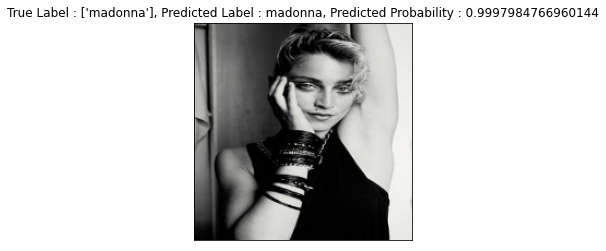

In [36]:
results = reconstructed_model.predict(np.expand_dims(test_data[1],axis = 0))
label = classes[np.argmax(results)]
print(label)
print(results)
plt.imshow(test_data[1].reshape((200,200,3)))
plt.xticks([])
plt.yticks([])
plt.title("True Label : {}, Predicted Label : {}, Predicted Probability : {}".format(test_labels[1],label,np.max(results)))

## lip detector

In [107]:
# import the necessary packages
import matplotlib.pyplot as plt
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../input/pyimage-lips-detector/detect-face-parts/shape_predictor_68_face_landmarks.dat')

# load the input image, resize it, and convert it to grayscale
image = cv2.imread('../input/face-image/IMG_20200828_112735.jpg')
# image = cv2.resize(image, (200,200))
image = imutils.resize(image, width=200)
attack_img = image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
main_img = []
roi_img = []
location = []
# detect faces in the grayscale image
rects = detector(gray, 1)

# loop over the face detections
for (i, rect) in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    # loop over the face parts individually
    for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
        # clone the original image so we can draw on it, then
        # display the name of the face part on the image
        clone = image.copy()
        cv2.putText(clone, name, (15, 15), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 0, 255), 1)
        # loop over the subset of facial landmarks, drawing the
        # specific face part
        for (x, y) in shape[i:j]:
            cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)
        # extract the ROI of the face region as a separate image
        (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
        location.append(x)
        location.append(y)
        location.append(w)
        location.append(h)
        roi = image[y:y + h, x:x + w]
        roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)
        roi_img.append(roi)
        main_img.append(clone)
location = np.array(location).reshape((-1,4))

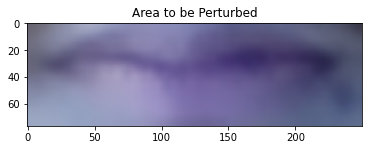

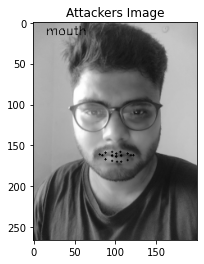

In [108]:
plt.title('Area to be Perturbed')
plt.imshow(roi_img[0])
plt.show()
plt.title('Attackers Image')
plt.imshow(cv2.cvtColor(main_img[0][:,:,0],cv2.COLOR_GRAY2RGB))
plt.show()

## Adversarial Attack

In [109]:
from __future__ import print_function
from scipy.io import savemat
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pylab as plt
from scipy.fftpack import dct, idct
import cv2
import os
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [110]:
from sklearn import preprocessing

loss_object = tf.keras.losses.CategoricalCrossentropy()

#### Original Image

([], <a list of 0 Text major ticklabel objects>)

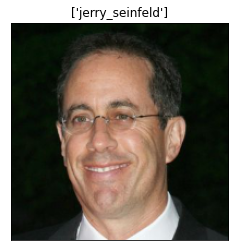

In [111]:
X_test = test_data
y_test = test_labels
plt.imshow(X_test[17])
plt.title(y_test[17])
plt.xticks([])
plt.yticks([])

In [112]:
def create_adversarial_pattern(input_image, input_label):    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = reconstructed_model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return (signed_grad,gradient,loss,prediction)

def display_images(image, description,class_names, model,i,true_label,pert_img,t):
    val='0'
    
    _, confidence, label = val,np.round(np.max(tf.convert_to_tensor(model(image))),2),class_names[np.argmax(tf.convert_to_tensor(model(image)))]
#     confidence = 

    plt.figure()
    plt.imshow(np.array(image[0]).reshape((200,200,3))*0.5 + 0.5)
    pert_img.append(np.array(image[0]).reshape((200,200,3))*0.5 + 0.5)
    pert_img.append(label)
    pert_img.append(i)
    pert_img.append(t)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   classes[label], confidence*100))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return(pert_img)

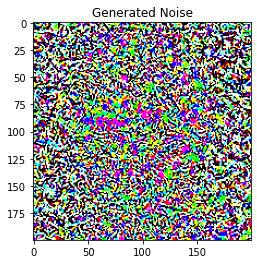

In [113]:
image = tf.convert_to_tensor(np.expand_dims(test_data[17],axis = 0),dtype = tf.float32)
input_label = tf.convert_to_tensor(y_true_enc[17].reshape((1,-1)),dtype =tf.float32)

perturbations,a,b,c = create_adversarial_pattern(image, input_label)
# perturbations = perturbations[0].reshape((100,100))

plt.imshow(np.array(perturbations[0]).reshape((200,200,3))*0.5 + 0.5)
plt.title('Generated Noise')
v = np.array(perturbations[0]).reshape((200,200,3))*0.5 + 0.5

## Adding Noise to Fake the Face Recognition model

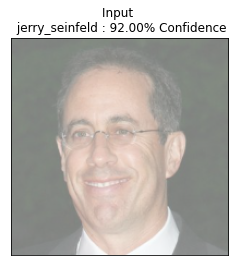

jerry_seinfeld


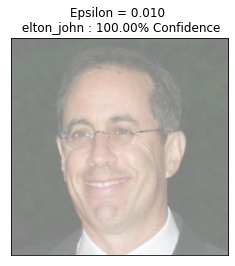

jerry_seinfeld


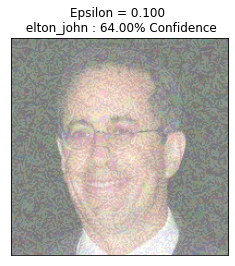

jerry_seinfeld


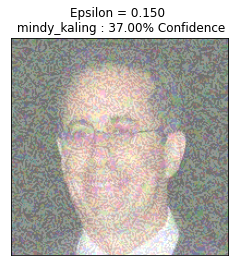

jerry_seinfeld


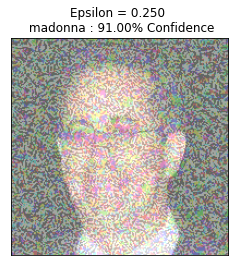

jerry_seinfeld


In [118]:
epsilons = [0, 0.01, 0.1, 0.15, 0.25]
pert_img_list = []

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
              for eps in epsilons]
class_names = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
for i, eps in enumerate(epsilons):
    
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    pert_img_list = display_images(adv_x, descriptions[i],class_names, reconstructed_model,i,y_true_enc[17],pert_img_list,test_data[17]) 
    print(y_pred_lbl[17])

In [119]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## Adversarial Network for Lips 

In [120]:
reconstructed_model(np.expand_dims(cv2.resize(attack_img,(200,200)),axis = 0))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 1., 0., 0., 0.]], dtype=float32)>

In [123]:
reconstructed_model(np.expand_dims(cv2.resize(X_test[21],(200,200)),axis = 0))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.00100813, 0.9904661 , 0.00221509, 0.00476423, 0.00154647]],
      dtype=float32)>

In [ ]:
reconstructed_model(np.expand_dims(cv2.resize(X_test[1],(200,200)),axis = 0))

In [121]:
from keras.utils.vis_utils import plot_model

def detector(img):
    if len(img.shape) !=4:
        img = np.expand_dims(img,axis = 0)
    prediction = reconstructed_model(img)
    label = classes[np.argmax(prediction)]
    if label == y_test[21]:
        print('Done!')
        y = 1
        
    else:
        print('Not Done!')
        y = 0
    prob = np.max(prediction)
    print(prediction)
    label_pred = classes[np.argmax(prediction)]
    return(prob,label_pred,y)
        
def get_features(test_data,img,w,h,model,new_test):
    model.fit(test_data,new_test,epochs = 10)
    features = model.predict(np.expand_dims(img,axis = 0))
    features = features.reshape((44,44,3))
    features = cv2.resize(features, (w,h))
#     print(np.array(features).shape)
#     plt.imshow(features)
#     plt.show()
    return(features)

def generator(loc,test_data,attacker_img):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(3, (3, 3), activation='tanh'))
#     model.summary()

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    new_test = []
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    for i in test_data:
        new_test.append(cv2.resize(i,(44,44)))
    new_test = np.array(new_test)
    x,y,w,h = loc[0,0],loc[0,1],loc[0,2],loc[0,3]
    img = X_test[21]
    lbl = y_true_enc[21]
    features = get_features(test_data,img,w,h,model,new_test)
    f = cv2.resize(features,(200,200))
    np.save('f',f)
    i = tf.convert_to_tensor(np.expand_dims(f,axis = 0),dtype = tf.float32)
    inp_lbl = tf.convert_to_tensor(y_true_enc[21].reshape((1,-1)),dtype =tf.float32)
    perturbations,a,b,c = create_adversarial_pattern(i, inp_lbl)
    perturbations = cv2.resize(np.array(perturbations[0]),(w,h))    
    attacker_img[y:y + h, x:x + w] = attacker_img[y:y + h, x:x + w] + 2*perturbations
    attacker_img = cv2.resize(attacker_img,(200,200))
#     plt.imshow(attacker_img)
    print(attacker_img.shape)
    prob, pred_label,y = detector(attacker_img)
    if y != 1:
        generator(loc,test_data,attacker_img)
    return(prob,pred_label,attacker_img)  

In [122]:
probability, predicted_label, attacker_image = generator(location, test_data,attack_img)

Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.2134 - accuracy: 0.2305
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.2077
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1015 - accuracy: 0.1768
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.1584
Epoch 5/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.1597
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.2313
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.5427
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0641 - accuracy: 0.5905
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0526 - accuracy: 0.5955
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.5973
(200, 200, 3)
Done!
tf.Tensor([[0. 1. 0

<Figure size 432x288 with 0 Axes>

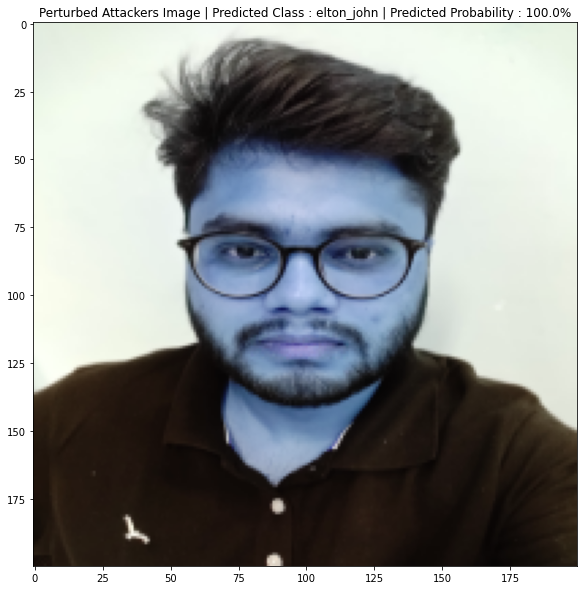

<Figure size 432x288 with 0 Axes>

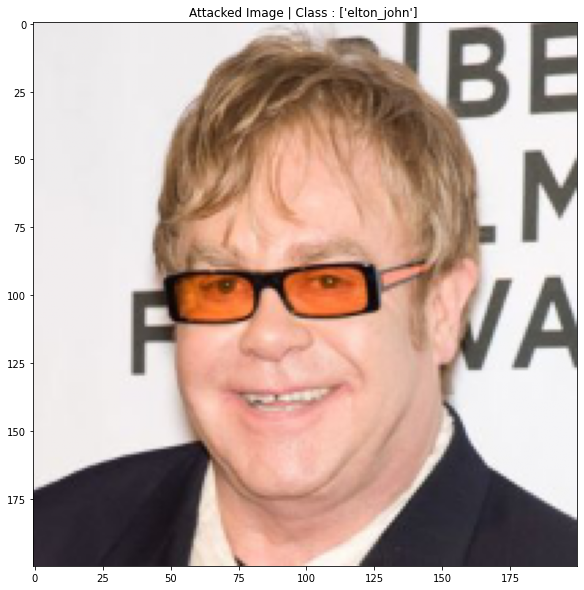

In [104]:
plt.figure(1)
plt.figure(figsize = (10,10))
plt.title('Perturbed Attackers Image | Predicted Class : {} | Predicted Probability : {}%'.format(predicted_label,probability*100))
plt.imshow(attacker_image)
plt.show()

plt.figure(2)
plt.figure(figsize = (10,10))
plt.title('Attacked Image | Class : {} '.format(y_test[21]))
plt.imshow(X_test[21])
plt.show()
